![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://raw.githubusercontent.com/PracticumAI/computer_vision/main/images/practicumai_computer_vision.png' alt='Practicum AI: Computer Vision icon' align='right' width=50>
***

# Optimizing Computer Vision Models

After a long day at the office, Kevin is getting ready to head home when his boss pops in. "Kevin, I need you to work on a project for me. We have a dataset of images of livestock, and we need to build a model that can accurately identify the different types of livestock in the images. We also need to be able to segment the livestock from the background. Can you handle this for me?" Kevin nods, and his boss hands him the dataset. "I need this done by the end of the week," his boss says as he walks away. Kevin looks at the dataset and sighs. It's going to be a long night.

As before, the dataset was found on Kaggle. [Check out the dataset information.](https://www.kaggle.com/datasets/amiteshpatra07/cattle-dataset-pig-sheep-cow-horse)

<img src="images/cattle_segmentation_cover.png" 
        alt="Image of a cow in a field." 
        width="1000" 
        height="200" 
        style="display: block; margin: 0 auto" />

Kevin already knows that YOLOv8 can handle object detection, but he's not sure how to handle segmentation. He decides to start with YOLOv8 and then look into segmentation. He also knows that he needs to optimize the model to get the best results. He decides to start by looking at the dataset and then move on to building the model.

## 1.  Import the libraries we will use

In [1]:
# Importing the necessary libraries
import os
import sys
import json
import random
import pathlib
import requests
import zipfile
import time

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from PIL import Image
import numpy as np
import pandas as pd
import torch
import yaml 
from ultralytics import YOLO
from ultralytics import settings

import helpers_02

import matplotlib.pyplot as plt
%matplotlib inline


Training on cuda


In [2]:
# Print Pytorch versions and check for GPU
print(f'Pytorch version: {torch.__version__}')
print(f'  Should be "True" if Pytorch was built for GPU: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'  Available GPU: {torch.cuda.get_device_name()}')
else:
    print('  No GPU available, will use CPU')

# Set the number of workers for data loading
num_workers = None  # To manually set the number of workers, change this to an integer

if num_workers is None:
    # If Slurm is being used, set the number of workers to a Slurm-provided value.
    # If Slurm is not being used, set the number of workers to the number of available CPU cores.
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
    elif os.getenv("SLURM_NTASKS_PER_NODE") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS_PER_NODE"))
    elif os.getenv("SLURM_NTASKS") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS"))
    else:
        num_workers = os.cpu_count()

print(f"Using {num_workers} workers for data loading.")

Pytorch version: 2.7.1+cu128
  Should be "True" if Pytorch was built for GPU: True
  Available GPU: NVIDIA B200
Using 4 workers for data loading.


## 2. Getting the data

Like Notebooks 1 and 2.2, we will have to find or download the dataset.

In [3]:
# Similar to the helpers_01 functions in the previous notebooks,
# The helpers_02.manage_data() function will check for and, if needed,
# download the dataset.
data_path = helpers_02.manage_data(url="https://data.rc.ufl.edu/pub/practicum-ai/Computer_Vision/cattle_segmentation.tar.gz", 
                                   filename="cattle_segmentation.tar.gz",
                                  folder_name='cattle_segmentation')

Found data at data/cattle_segmentation.


In [4]:
# Manage YOLO settings to set correct path to data folder
settings.update({"datasets_dir": data_path})

## 3. Explore the dataset

We will take a look at the dataset to see what it contains. We will also look at the annotations file, which contains the bounding box information for each image.

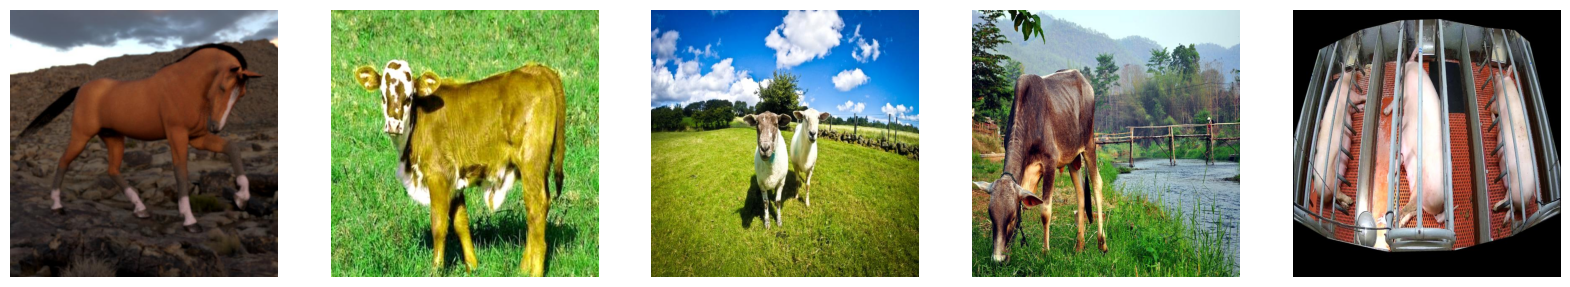

File: data/cattle_segmentation/train/labels/HolsteinFriesiancattle123_c_jpg.rf.743fd0e7c9653ab040a557ea89ca95ff.txt
  0 0.8994140625 0.458984375 0.919921875 0.4462890625 0.921875 0.4248046875 0.908203125 0.3955078125 0.90234375 0.3623046875 0.9326171875 0.353515625 0.939453125 0.3408203125 0.9296875 0.3212890625 0.892578125 0.2900390625 0.875 0.2548828125 0.8623046875 0.24609375 0.8427734375 0.244140625 0.7861328125 0.271484375 0.7236328125 0.267578125 0.7001953125 0.275390625 0.6357421875 0.26171875 0.5751953125 0.263671875 0.5400390625 0.251953125 0.4599609375 0.25390625 0.4462890625 0.248046875 0.3720703125 0.25 0.3017578125 0.244140625 0.2763671875 0.23046875 0.2509765625 0.2265625 0.1982421875 0.224609375 0.1611328125 0.232421875 0.1044921875 0.234375 0.0859375 0.2568359375 0.08203125 0.2861328125 0.083984375 0.3798828125 0.091796875 0.3994140625 0.0859375 0.4521484375 0.091796875 0.4580078125 0.09375 0.5126953125 0.087890625 0.5166015625 0.072265625 0.5751953125 0.08203125 0.7333

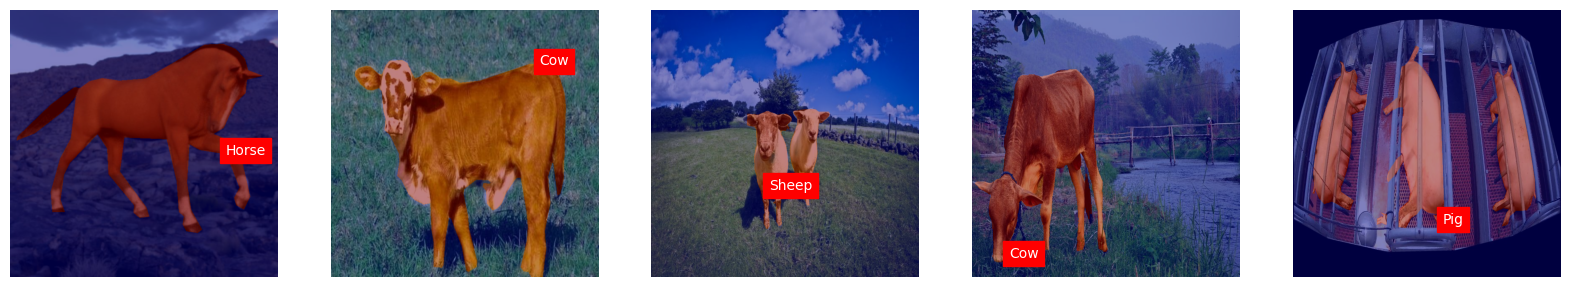

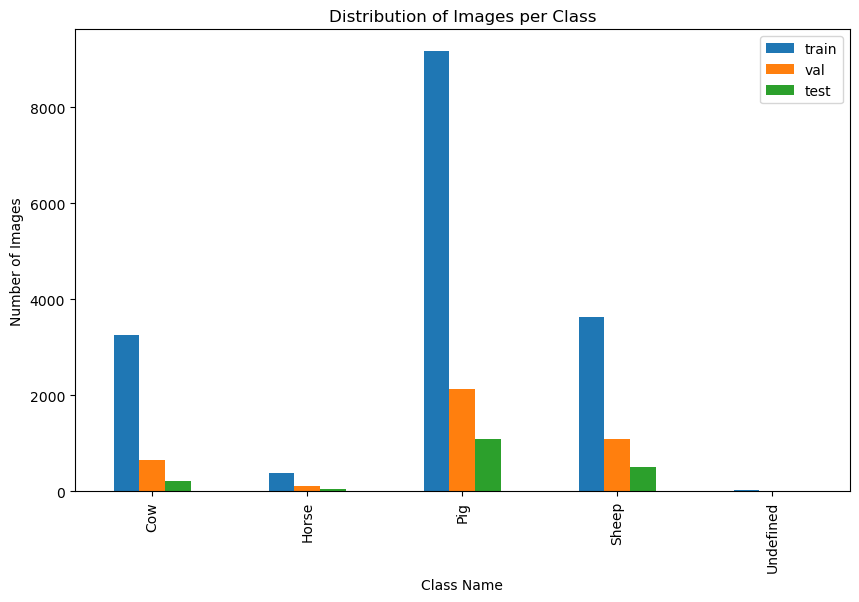

In [5]:
# Make a histogram of the number of images in each class
def explore_data(data_path, show_picture=True, show_annotation=True, show_segmentation=True, show_hist=True):

    # Define the class names
    class_names = ['Cow', 'Horse', 'Pig', 'Sheep', 'Undefined']

    # Initialize sample images list to store paths
    sample_images = []

    # Examine some sample images
    if show_picture:
        # Get valid image folders 
        image_folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))] 

        for i in range(5):
            folder = random.choice(image_folders) 
            img_path = os.path.join(data_path, folder, 'images', random.choice(os.listdir(os.path.join(data_path, folder, 'images'))))
            sample_images.append(img_path)

        # Plot the sample images
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        for i, img_path in enumerate(sample_images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.show()

    # Examine the first annotation file
    if show_annotation:
        annotation_files = []
        for folder in os.listdir(data_path):
            if os.path.isdir(os.path.join(data_path, folder)):
                annotation_folder = os.path.join(data_path, folder, 'labels')
                if os.path.exists(annotation_folder):
                    for file in os.listdir(annotation_folder):
                        annotation_files.append(os.path.join(annotation_folder, file))
        if annotation_files:
            annotation_file = annotation_files[0]  # Show only the first annotation file
            with open(annotation_file, 'r') as f:
                print(f"File: {annotation_file}")
                for i, line in enumerate(f):
                    if i > 4:
                        break
                    print(f"  {line.strip()}")

    # Plot the same sample images with their associated, labeled segmentation masks
    if show_segmentation and sample_images:
        # Find corresponding annotation files for the sample images
        sample_annotations = []
        for img_path in sample_images:
            folder = os.path.dirname(os.path.dirname(img_path))
            annotation_path = os.path.join(folder, 'labels', os.path.basename(img_path).replace('.jpg', '.txt'))
            sample_annotations.append((img_path, annotation_path))

        # Plot the sample images with segmentation masks
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        for i, (img_path, annotation_path) in enumerate(sample_annotations):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            with open(annotation_path, 'r') as f:
                for line in f:
                    class_id, *polygon = map(float, line.strip().split())
                    polygon = np.array(polygon).reshape(-1, 2) * [img.shape[1], img.shape[0]]
                    polygon = polygon.astype(np.int32)
                    cv2.fillPoly(mask, [polygon], 255)
            axes[i].imshow(img)
            axes[i].imshow(mask, alpha=0.5, cmap='jet')
            axes[i].axis('off')
            # Add class name above the segmentation mask
            if len(polygon) > 0:
                x, y = polygon[0]
                axes[i].text(x, y, class_names[int(class_id)], color='white', backgroundcolor='red')
        plt.show()

    # Make a histogram of the number of images in each class
    if show_hist:
        def get_class_counts(folder_path):  # Change from data_path to folder_path
            class_counts = {}
            labels_path = os.path.join(folder_path, 'labels')  # Add labels path
            for filename in os.listdir(labels_path):  # Update listdir
                with open(os.path.join(labels_path, filename), 'r') as f:
                    for line in f:
                        class_id = int(line.split(' ')[0])  # Assuming labels are in YOLO format
                        class_counts[class_id] = class_counts.get(class_id, 0) + 1
            return class_counts

        train_counts = get_class_counts(os.path.join(data_path, 'train'))  # Add os.path.join
        val_counts = get_class_counts(os.path.join(data_path, 'valid'))
        test_counts = get_class_counts(os.path.join(data_path, 'test'))
        num_classes = len(class_names)

        data_counts = {
            'train': pd.Series(train_counts),
            'val': pd.Series(val_counts),
            'test': pd.Series(test_counts)
        }
        df = pd.DataFrame(data_counts)

        df.plot.bar(figsize=(10, 6))
        plt.xlabel('Class Name')
        plt.xticks(np.arange(num_classes), class_names)
        plt.ylabel('Number of Images')
        plt.title('Distribution of Images per Class')
        plt.legend()
        plt.show()

explore_data(data_path, show_picture=True, show_annotation=True, show_segmentation=True, show_hist=True)


As with the fruit detection notebook, there are some issues with this cattle dataset!
- Not all the animals in some of the images are annotated.
- The annotation file names are the same as the image names, but with a .txt extension.
- The annotations file contains the class ID of the animal (0 corresponds to 'Cow', etc.), and the segmentation coordinates. 
- The segmentation coordinates are the pixel locations for the vertices of the segmenting polygons.
- The segmentation coordinates are normalized, meaning that they are scaled to be between 0 and 1.
- The dataset is very imbalanced, with a lot more pigs than other animals, and comparatively almost no horses.

## 4. Create the YAML file
YAML stands for "YAML Ain't Markup Language" and is a human-readable data serialization format. A YAML file is used to define the dataset configuration for training a YOLOv8 model. YAML configuration files are popular in deep learning because they are relatively easy for humans to read and write, with the goal being to increase transparency and reproducibility.

In [6]:
# Create a YAML file for the YOLOv8 model configuration

def create_yaml(data_path, class_names, yaml_file='cattle_segmentation_data.yaml'):
    # Creates a YOLOv8 data.yaml file.
    
    yaml_dict = {
        # 'path': data_path,  # Path to your dataset
        'train': data_path + '/train/images',  # Relative path to training images
        'val': data_path + '/valid/images',    # Relative path to validation images
        'test': data_path + '/test/images',    # Relative path to testing images

        'num_classes': len(class_names),   # Number of classes
        'names': class_names      # List of class names
    }

    with open(yaml_file, 'w') as outfile:
        yaml.dump(yaml_dict, outfile, default_flow_style=False)

    print(f'YAML file created: {yaml_file}')

data_dir = 'cattle_segmentation'
class_names = ['Cow', 'Horse', 'Pig', 'Sheep', 'Undefined']

create_yaml(data_path, class_names) 

YAML file created: cattle_segmentation_data.yaml


## 5. Create and fit the model

We will create a YOLOv8 model and fit it to the data. YOLOv8 has a lot of hyperparameters that can be tuned, but we will use the default values for now. For more information on its hyperparameters, [check out YOLOv8's documentation](https://docs.ultralytics.com/modes/train/).

Another neat feature of YOLOv8 is that by default it provides several evaluation metrics, such as the loss, precision, recall, and F1 score. This is very useful for monitoring the model's performance during training.

In [ ]:
# Make and train the YOLOv8 model using Lightning wrapper
print("="*60)
print("TRAINING YOLOv8 SEGMENTATION MODEL WITH LIGHTNING")
print("="*60)

# Train using Lightning wrapper for better experiment tracking and consistency
model, trainer, yolo_model = helpers_02.train_yolo_model(
    data_config='cattle_segmentation_data.yaml',
    model_type='yolov8n-seg',  # Segmentation model
    max_epochs=10,
    img_size=640,
    accelerator='auto',
    devices='auto',
    experiment_name='cattle_segmentation'
)

print("\nTraining completed! Model evaluation will be shown below.")

TRAINING YOLOv8 SEGMENTATION MODEL WITH LIGHTNING
YOLO LIGHTNING TRAINING SETUP
Model type: yolov8n-seg
Data config: cattle_segmentation_data.yaml
Image size: 640
Max epochs: 10
Learning rate: 0.01
Accelerator: auto
Devices: auto


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting YOLO training with Lightning integration...
Ultralytics 8.3.157 🚀 Python-3.12.11 torch-2.7.1+cu128 CUDA:0 (NVIDIA B200, 182642MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cattle_segmentation_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=cattle_segmentation, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

train: Scanning /blue/ufhpc/magitz/PracticumAI/computer_vision/data/cattle_segmentation/train/labels.cache... 4867 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4867/4867 [00:00<?, ?it/s]

train: WARNING ⚠️ /blue/ufhpc/magitz/PracticumAI/computer_vision/data/cattle_segmentation/train/images/IMG_20231019_154915_jpg.rf.7aee29930d5cfe4ac5fa1a5d33c01fa0.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /blue/ufhpc/magitz/PracticumAI/computer_vision/data/cattle_segmentation/train/images/IMG_20231019_154933_jpg.rf.4ae9f4ce4a8dc33f4afd1d7ca702cbd7.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /blue/ufhpc/magitz/PracticumAI/computer_vision/data/cattle_segmentation/train/images/IMG_20231024_093804_jpg.rf.58a6ffb41d24f9a2971831c6cccc2d92.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /blue/ufhpc/magitz/PracticumAI/computer_vision/data/cattle_segmentation/train/images/IMG_20231024_094048_jpg.rf.f6094ddd9032ec1afd74af8c903ef7a2.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /blue/ufhpc/magitz/PracticumAI/computer_vision/data/cattle_segmentation/train/images/pig4_11_jpg.rf.b73fceb3d429fb356b2cf5dcf757fe2d.jpg: 1 duplicate labels removed



/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 117.1±47.1 MB/s, size: 64.3 KB)


val: Scanning /blue/ufhpc/magitz/PracticumAI/computer_vision/data/cattle_segmentation/valid/labels.cache... 1195 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1195/1195 [00:00<?, ?it/s]
/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Plotting labels to lightning_logs/cattle_segmentation/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to lightning_logs/cattle_segmentation
Starting training for 10 epochs...
Closing dataloader mosaic


/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.76G      3.389      6.728      4.516       4.11         51        640:  53%|█████▎    | 162/305 [01:47<10:34,  4.44s/it]

## 6. Evaluate the results

Let's look at those evaluation metrics we mentioned above. YOLOv8 creates a **runs** folder that stores each training run. We'll pull them up here and examine what they mean.

In [ ]:
# Plot the evaluation results

# Find the latest training run
training = sorted(os.listdir('runs/segment/.'))
latest_training = training[-1]
print(f'Latest training run: {latest_training}')

# Plot the .png files in the latest training run
for file in os.listdir(f'runs/segment/{latest_training}'):
    if file.endswith('.png'):
        # Exclude the normalized confusion matrix since it's redundant
        if 'normalized' in file:
            continue
        img = Image.open(f'runs/segment/{latest_training}/{file}')
        plt.imshow(img)
        plt.axis('off')
        plt.show()

## Stats Re-Refresher

Here is a link to the Stat Term section in Notebook [02_boxes_of_fruit.ipynb], in case you need to look at it again. 

Link: [Breaking down the graphs](02_boxes_of_fruit.ipynb#Breaking-down-the-graphs)

> **Note:** On Google Colab the link will only open notebook 02_boxes_of_fruit, you'll have to navigate down to the "Breaking down the graphs" section on your own!

In addition to the evaluation graphs, we can look at the predictions themselves. 

In [ ]:
# Plot the labels and predictions from the last training run

# Load the images
img1 = Image.open(f'runs/segment/{latest_training}/val_batch2_labels.jpg')
img2 = Image.open(f'runs/segment/{latest_training}/val_batch2_pred.jpg')

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Ground Truth')
axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Predictions')
plt.show()


The predictions above aren't perfect, but they are pretty good! The model is able to detect the animals in the images and put segmentation masks over them. For the most part, the segmentation masks hold up to the animals's shapes, but it doesn't always predict the right class. For example, the model sometimes predicts a cow as a pig, or a horse as a sheep. What are some ways we could improve the model's performance?

## 7. Inference
How does the model fare on some test images? After you run the cell below:
1. Find your own image of a cow, pig, sheep, or horse (or any other animal you like).
2. Upload it to this folder.
3. Add or edit the code below to run on the new image rather than images in the test folder.

In [ ]:
# Get ten random test images
test_images = []
for img_name in os.listdir(os.path.join(data_path, 'test', 'images')):
    img_path = os.path.join(data_path, 'test', 'images', img_name)
    test_images.append(img_path)
test_images = random.sample(test_images, 10)

# Plot the test images
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, img_path in enumerate(test_images):
    img = Image.open(img_path)
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
plt.show()

# Use our Lightning wrapper's evaluation function for consistent results
print("="*60)
print("MODEL EVALUATION ON TEST DATA")
print("="*60)
test_metrics = helpers_02.evaluate_yolo_model(yolo_model, 'cattle_segmentation_data.yaml')

# Run the model on the test images using our visualization function
print("\nVisualization of predictions:")
# Select first 5 images for detailed visualization
sample_test_images = test_images[:5]
helpers_02.visualize_yolo_results(yolo_model, sample_test_images, conf_threshold=0.25)

# Also show individual predictions as before for detailed inspection
print("\nDetailed individual predictions:")
infer_results = yolo_model(sample_test_images)

for img_path, result in zip(sample_test_images, infer_results):
    img = Image.open(img_path)
    img = img.resize((640, 640))
    plt.imshow(img)
    plt.axis('off')

    # Check if segmentation masks are available
    if result.masks is not None:
        # Access segmentation masks and class information
        masks = result.masks.data.cpu().numpy()  # Masks are on the CPU
        class_ids = result.boxes.cls.cpu().numpy()  # Class IDs are on the CPU
        confidences = result.boxes.conf.cpu().numpy()  # Confidences are on the CPU

        for mask, class_id, conf in zip(masks, class_ids, confidences):
            # Create a mask overlay
            mask = mask.squeeze()
            plt.imshow(mask, alpha=0.05, cmap='spring')

            # Get the contour of the mask
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                plt.plot(contour[:, 0, 0], contour[:, 0, 1], color='red', linewidth=2)
            
            # Display class name and confidence score for each instance
            mask_center_x = int(mask.shape[1] / 2)
            mask_center_y = int(mask.shape[0] / 2)
            plt.text(mask_center_x, mask_center_y, f"{result.names[int(class_id)]} {conf:.2f}", color='white', backgroundcolor='red')
    else:
        plt.text(320, 320, "No class detected", fontsize=12, color='white', backgroundcolor='red', ha='center')

    plt.show()

## 8. Explore hyperparameters

Now that you have a good baseline, consider how you might deal with this model's issues.
- How would you address issues in the dataset?
- How would you optimize training?

A good first place to start would be YOLOv8's documentation so you can understand what hyperparameters you have access to and how changing them will affect training. Make some adjustments and see how high you can get your cattle segmentation F1 score!

## Bonus Exercises

- You might have noticed the *yolov8n-seg.pt* file that is added to the folder when you load YOLO. That is the pre-trained model using the [COCO dataset](https://cocodataset.org/#home). The YOLOv8 documentation linked above provides instructions for transfer learning and fine-tuning with the pre-trained model. Give it a shot!

- The dataset is imbalanced, with a lot more pigs than other animals. How would you address this issue? (Image augmentation is a little more difficult with segmentation tasks, but there are still some techniques you could try. Check out the [albumentations library](https://albumentations.ai/docs/getting_started/image_augmentation/).)

## 9. Model Comparison and Hyperparameter Tuning

Now that we have a Lightning wrapper for YOLOv8, let's explore some advanced features that make model comparison and optimization easier.

In [ ]:
# Example: Compare different YOLO model sizes
print("="*60)
print("TRAINING MULTIPLE MODELS FOR COMPARISON")
print("="*60)

# Train a smaller YOLOv8 nano model for comparison
print("Training YOLOv8 Nano (faster, smaller)...")
nano_model, nano_trainer, nano_yolo = helpers_02.train_yolo_model(
    data_config='cattle_segmentation_data.yaml',
    model_type='yolov8n-seg',
    max_epochs=5,  # Fewer epochs for demonstration
    img_size=640,
    experiment_name='cattle_nano'
)

# Train a larger YOLOv8 small model for comparison
print("\nTraining YOLOv8 Small (slower, larger)...")
small_model, small_trainer, small_yolo = helpers_02.train_yolo_model(
    data_config='cattle_segmentation_data.yaml',
    model_type='yolov8s-seg',
    max_epochs=5,  # Fewer epochs for demonstration
    img_size=640,
    experiment_name='cattle_small'
)

# Compare the models
models_to_compare = {
    'YOLOv8n-seg (Nano)': nano_yolo,
    'YOLOv8s-seg (Small)': small_yolo
}

comparison_results = helpers_02.compare_yolo_models(
    models_to_compare, 
    'cattle_segmentation_data.yaml'
)

In [ ]:
# Example: Automated hyperparameter tuning
print("="*60)
print("AUTOMATED HYPERPARAMETER TUNING")
print("="*60)

# Define hyperparameter grid
hyperparams_grid = {
    'learning_rate': [0.01, 0.005],
    'weight_decay': [0.0005, 0.001],
    'img_size': [640]  # Keep constant for this example
}

# Run hyperparameter tuning
tuning_results = helpers_02.train_yolo_with_hyperparameter_tuning(
    data_config='cattle_segmentation_data.yaml',
    model_type='yolov8n-seg',
    hyperparams_grid=hyperparams_grid,
    max_epochs=3  # Short runs for demonstration
)

print("\nHyperparameter tuning completed!")
print("Check the results above to see which configuration performed best.")

## 10. Benefits of Lightning Integration

By wrapping YOLOv8 with PyTorch Lightning, we've gained several advantages while maintaining the power of YOLO's optimized detection pipeline:

### 🚀 **Enhanced Experiment Management**
- **Consistent logging**: All experiments are logged to TensorBoard in a standardized format
- **Easy comparison**: Models can be compared side-by-side with consistent metrics
- **Reproducible results**: Seed setting and configuration tracking ensure reproducibility

### 🔧 **Simplified Training Workflow**
- **Unified API**: Same function calls as our classification notebooks (helpers_01.py)
- **Automatic callbacks**: Early stopping and checkpointing handled automatically
- **Device management**: Automatic GPU/CPU detection and multi-GPU support

### 📊 **Better Model Comparison**
- **Standardized evaluation**: All models evaluated with the same metrics
- **Automated hyperparameter tuning**: Grid search with organized results
- **Performance tracking**: Easy identification of best-performing configurations

### 💡 **Educational Consistency**
- **Learning transfer**: Knowledge from classification notebooks applies here
- **Code reusability**: Similar patterns and functions across all notebooks
- **Best practices**: Industry-standard training and evaluation workflows

### 🎯 **Maintained YOLO Advantages**
- **Optimized performance**: Still uses YOLO's efficient training pipeline
- **All YOLO features**: Access to YOLO's data augmentation, loss functions, etc.
- **Native compatibility**: Works with existing YOLO datasets and configurations

This hybrid approach gives you the best of both worlds: the ease and standardization of Lightning with the specialized efficiency of YOLOv8 for object detection and segmentation tasks.